<a href="https://colab.research.google.com/github/YuHsin-Chen1221/Multi-tasks-Peptide-Transformers-/blob/main/AMP_Classification_with_Multi_Head_Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install biopython
!pip install torch torchvision

In [22]:
# data loading
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_excel("general_amps.xlsx")
df.head()

Saving general_amps.xlsx to general_amps (1).xlsx


,DRAMP_ID,Sequence,Sequence_Length,Name,Swiss_Prot_Entry,Family,Gene,Source,Activity,Protein_existence,...,N-terminal_Modification,C-terminal_Modification,Other_Modifications,Stereochemistry,Cytotoxicity,Binding_Traget,Pubmed_ID,Reference,Author,Title
0,DRAMP00005,SLGPAIKATRQVCPKATRFVTVSCKKSDCQ,30,Epicidin 280 (Bacteriocin),O54220,Belongs to the lantibiotic family (Class I bac...,eciA,Staphylococcus epidermidis BN 280 (Gram-positi...,"Antimicrobial, Antibacterial, Anti-Gram+",Protein level,...,Oxypropionylation,Not metioned clearly,There are possible lanthionine(Lan)/3-methylla...,L,No cytotoxicity information found,Not found,9726851,Appl Environ Microbiol. 1998 Sep;64(9):3140-3146.,"Heidrich C, Pag U, Josten M, Metzger J, Jack R...","Isolation, characterization, and heterologous ..."
1,DRAMP00017,VTSWSLCTPGCTSPGGGSNCSFCC,24,Microbisporicin A1 (Bacteriocin),No entry found,Belongs to the lantibiotic family (Class I bac...,Not found,Microbispora corallina (Gram-positive bacteria),"Antimicrobial, Antibacterial",Protein level,...,Free,Amidation and Cyclization,①There are five thioether intramolecular bridg...,L,No cytotoxicity information found,Not found,18215770,Chem Biol. 2008 Jan;15(1):22-31.,"Castiglione F, Lazzarini A, Carrano L, Corti E...",Determining the structure and mode of action o...
2,DRAMP00032,GNGVLKTISHECNMNTWQFLFTCC,24,Ruminococcin A (RumA; Bacteriocin),"P83674, P83676, P83677, Q8VLK0, Q9K381, P83675...",Belongs to the type A lantibiotic family (Clas...,rumA1 AND rumA2 AND,Ruminococcus gnavus & Ruminococcus hansenii (G...,"Antimicrobial, Antibacterial, Anti-Gram+",Protein level,...,Free,Cyclization (possibly),① It is highly probable that (i) Ser9 and the ...,L,No cytotoxicity information found,Cell membrane,11526013##11741840##12089024,Appl Environ Microbiol. 2001 Sep;67(9):4111-41...,"Dabard J, Bridonneau C, Phillipe C, Anglade P,...","Ruminococcin A, a new lantibiotic produced by ..."
3,DRAMP00063,SSSGWLCTLTIECGTIICACR,21,Lantibiotic michiganin-A (Bacteriocin),Q09T02,Belongs to the type B lantibiotic family (Clas...,micA,Clavibacter michiganensis subsp. Michiganensis...,"Antimicrobial, Antibacterial",Protein level,...,Free,Free,All of the threonine residues undergo dehydrat...,L,No cytotoxicity information found,Not found,16957199,Appl Environ Microbiol. 2006 Sep;72(9):5814-5821.,"Holtsmark I, Mantzilas D, Eijsink VG, Brurberg...","Purification, characterization, and gene seque..."
4,DRAMP00068,MSWLNFLKYIAKYGKKAVSAAWKYKGKVLEWLNVGPTLEWVWQKLK...,51,Aureocin A53 (Bacteriocin),Q8GPI4,Belongs to the class II bacteriocin,aucA,Staphylococcus aureus A53 (Gram-positive bacte...,"Antimicrobial, Antibacterial, Anti-Gram+",Protein level,...,Formylation,Free,NaN,L,No cytotoxicity information found,Cell membrane,12054867,J Mol Biol. 2002 Jun 7;319(3):745-756.,"Netz DJ, Pohl R, Beck-Sickinger AG, Selmer T, ...",Biochemical characterisation and genetic analy...


In [23]:
# data cleaning
df_cleaned = df[['DRAMP_ID', 'Sequence', 'Sequence_Length', 'Activity']].copy()
df_cleaned = df_cleaned[df_cleaned['Sequence_Length'] <= 50]
df_cleaned.head()

,DRAMP_ID,Sequence,Sequence_Length,Activity
0,DRAMP00005,SLGPAIKATRQVCPKATRFVTVSCKKSDCQ,30,"Antimicrobial, Antibacterial, Anti-Gram+"
1,DRAMP00017,VTSWSLCTPGCTSPGGGSNCSFCC,24,"Antimicrobial, Antibacterial"
2,DRAMP00032,GNGVLKTISHECNMNTWQFLFTCC,24,"Antimicrobial, Antibacterial, Anti-Gram+"
3,DRAMP00063,SSSGWLCTLTIECGTIICACR,21,"Antimicrobial, Antibacterial"
5,DRAMP00069,EYHLMNGANGYLTRVNGKTVYRVTKDPVSAVFGVISNCWGSAGAGF...,50,"Antimicrobial, Antibacterial, Anti-Gram+"


In [37]:
# sequence pre-processing & embedding

import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn


def build_vocab(sequences):
    vocab = set(''.join(sequences))
    vocab = sorted(list(vocab))
    vocab_dict = {aa: idx + 1 for idx, aa in enumerate(vocab)}  # 0 保留給 padding
    vocab_dict['PAD'] = 0
    return vocab_dict

# Tokenization
def tokenize_sequence(sequence, vocab):
    return [vocab[aa] for aa in sequence]

# 執行 vocab + tokenization + padding
sequences = df_cleaned['Sequence'].tolist() # Corrected column name
vocab = build_vocab(sequences)
tokenized = [torch.tensor(tokenize_sequence(seq, vocab)) for seq in sequences]
padded = torch.nn.utils.rnn.pad_sequence(tokenized, batch_first=True, padding_value=0) # Corrected pad_sequence


# 補齊長度到固定長度（50）
MAX_LEN = 50
padded = padded[:, :MAX_LEN] if padded.shape[1] > MAX_LEN else \
         torch.nn.functional.pad(padded, (0, MAX_LEN - padded.shape[1]), value=0)

print("Padded shape:", padded.shape)  # 應該是 (num_sequences, 50)

# 建立嵌入層
vocab_size = len(vocab)
embedding_dim = 128  # 可調整
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0) # Corrected num_embeddings
embedded_output = embedding(padded)

print("Embedding shape:", embedded_output.shape)  # (num_sequences, 50, embedding_dim)

# label encoding

label_corrections = {
    'anitifungal': 'antifungal',
    'antbacterial': 'antibacterial',
    'anti mammalian cells': 'mammalian cells',
    'antic': 'anticancer',
    'cytotoxicity': 'cytotoxic',
    'hemolytic against mammalian cells': 'hemolytic',
    'antiviral(sars-cov-2)': 'antiviral',
    'not found': None,
    'unknown': None,
    'low hemolytic and toxic effects': 'hemolytic',
    'non-antibacterial': None,
    'non-antimicrobial': None,
    # Add more corrections for repetitive labels
    'antibiotic': 'antibacterial', # Consolidate 'antibiotic' under 'antibacterial'
    'antigram': 'antigram+', # Consolidate 'antigram' under 'antigram+'
    'antitumor': 'anticancer', # Consolidate 'antitumor' under 'anticancer'
    'cytolysis': 'cytotoxic', # Consolidate 'cytolysis' under 'cytotoxic'
    'cytolytic': 'cytotoxic', # Consolidate 'cytolytic' under 'cytotoxic'
    'antiviral(sarscov2)': 'antiviral', # Consolidate 'antiviral(sarscov2)' under 'antiviral'
}

def clean_labels(label_string):
    label_string = label_string.lower().replace(' ', '').replace('-', '') # Remove spaces and dashes
    labels = re.split(r',', label_string)
    cleaned = set()
    for label in labels:
        label = label.strip()
        if label in label_corrections:
            corrected = label_corrections[label]
            if corrected:
                cleaned.add(corrected)
        else:
            cleaned.add(label)
    return list(cleaned)


df_cleaned['Cleaned_Labels'] = df_cleaned['Activity'].apply(clean_labels)

all_cleaned_labels = set()
for labels in df_cleaned['Cleaned_Labels']:
    all_cleaned_labels.update(labels)

label_to_idx = {label: idx for idx, label in enumerate(sorted(all_cleaned_labels))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

num_labels = len(label_to_idx)
print("Label dictionary:", label_to_idx)
print("num of labels:", num_labels)

Padded shape: torch.Size([10579, 50])
Embedding shape: torch.Size([10579, 50, 128])
Label dictionary: {'antiallodynic': 0, 'antibacterial': 1, 'antibiofilm': 2, 'anticancer': 3, 'anticryptococcal': 4, 'antidiabetic': 5, 'antifungal': 6, 'antigram+': 7, 'antihiv': 8, 'antihsv': 9, 'antiinflammatory': 10, 'antilisterial': 11, 'antimalarial': 12, 'antimammaliancells': 13, 'antimicrobial': 14, 'antinociceptive': 15, 'antiparasitic': 16, 'antiplasmodial': 17, 'antiproliferative': 18, 'antiprotozoal': 19, 'antiviral': 20, 'archaeolytic': 21, 'candidacidal': 22, 'celldegranulating': 23, 'chemotactic': 24, 'cytotoxic': 25, 'defenseresponse': 26, 'enzymeinhibitor': 27, 'hemolytic': 28, 'hemolyticagainstmammaliancells': 29, 'immunomodulatory': 30, 'insecticidal': 31, 'lowhemolyticandtoxiceffects': 32, 'mammaliancells': 33, 'neuropeptide': 34, 'nonantibacterial': 35, 'nonantimicrobial': 36, 'notfound': 37, 'proteinkinaseinhibitoractivity': 38, 'proteolytic': 39, 'toxin': 40, 'woundhealing': 41}
n

In [38]:
import torch
from torch.utils.data import Dataset, DataLoader

# convert cleaned labels to multi-hot encoded tensors
def labels_to_multihot(cleaned_labels, label_to_idx):
    multihot = torch.zeros(len(label_to_idx))
    for label in cleaned_labels:
        if label in label_to_idx:
            multihot[label_to_idx[label]] = 1
    return multihot

multihot_labels = torch.stack([labels_to_multihot(labels, label_to_idx) for labels in df_cleaned['Cleaned_Labels']])

# Create a custom Dataset
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Instantiate the dataset and dataloader
dataset = SequenceDataset(padded, multihot_labels)
batch_size = 32  # Define your batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Number of samples in dataset:", len(dataset))
print("Number of batches in dataloader:", len(dataloader))

# Example of a batch from the dataloader
for seq_batch, label_batch in dataloader:
    print("Sequence batch shape:", seq_batch.shape)
    print("Label batch shape:", label_batch.shape)
    break # Print only one batch example

Number of samples in dataset: 10579
Number of batches in dataloader: 331
Sequence batch shape: torch.Size([32, 50])
Label batch shape: torch.Size([32, 42])


In [39]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size # 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Number of samples in training dataset:", len(train_dataset))
print("Number of batches in training dataloader:", len(train_dataloader))
print("Number of samples in testing dataset:", len(test_dataset))
print("Number of batches in testing dataloader:", len(test_dataloader))

Number of samples in training dataset: 8463
Number of batches in training dataloader: 265
Number of samples in testing dataset: 2116
Number of batches in testing dataloader: 67


In [40]:
# sequence-based transformer model with multi-head attention

import torch
import torch.nn as nn

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, hidden_dim, max_len=50, num_layers=2, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]  # Shape: (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Shape: (batch_size, seq_len, embed_dim)

        # Pooling: Mean over the sequence dimension
        x = x.mean(dim=1)  # Shape: (batch_size, embed_dim)

        return self.classifier(x)  # Output logits for each class


Epoch 1 | Train Loss: 0.1939 | Train Accuracy: 0.9499 | Eval Loss: 0.0785 | Eval Accuracy: 0.9663
Epoch 2 | Train Loss: 0.0781 | Train Accuracy: 0.9659 | Eval Loss: 0.0769 | Eval Accuracy: 0.9663
Epoch 3 | Train Loss: 0.0767 | Train Accuracy: 0.9659 | Eval Loss: 0.0736 | Eval Accuracy: 0.9670
Epoch 4 | Train Loss: 0.0720 | Train Accuracy: 0.9687 | Eval Loss: 0.0698 | Eval Accuracy: 0.9705
Epoch 5 | Train Loss: 0.0681 | Train Accuracy: 0.9710 | Eval Loss: 0.0652 | Eval Accuracy: 0.9730
Epoch 6 | Train Loss: 0.0630 | Train Accuracy: 0.9739 | Eval Loss: 0.0614 | Eval Accuracy: 0.9752
Epoch 7 | Train Loss: 0.0597 | Train Accuracy: 0.9755 | Eval Loss: 0.0600 | Eval Accuracy: 0.9755
Epoch 8 | Train Loss: 0.0571 | Train Accuracy: 0.9768 | Eval Loss: 0.0583 | Eval Accuracy: 0.9768
Epoch 9 | Train Loss: 0.0551 | Train Accuracy: 0.9776 | Eval Loss: 0.0575 | Eval Accuracy: 0.9769
Epoch 10 | Train Loss: 0.0529 | Train Accuracy: 0.9786 | Eval Loss: 0.0559 | Eval Accuracy: 0.9777


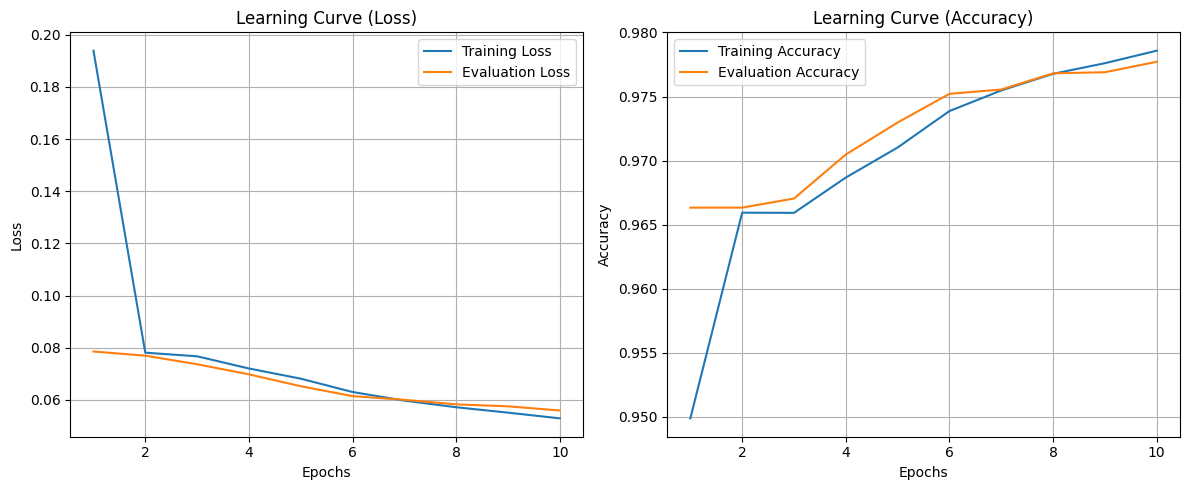

In [41]:
# model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerClassifier(
    vocab_size=len(vocab),
    embed_dim=128,
    num_heads=4,
    num_classes=42,
    hidden_dim=256,
    max_len=50,
    num_layers=2,
    dropout=0.1
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

# Lists to store metrics for plotting
train_losses = []
eval_losses = []
train_accuracies = []
eval_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct_predictions = 0
    train_total_samples = 0
    for sequences, labels in train_dataloader:
        sequences, labels = sequences.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calculate training accuracy
        predicted = torch.sigmoid(outputs) > 0.5
        train_correct_predictions += (predicted == labels).sum().item()
        train_total_samples += labels.numel()

    # Evaluation phase
    model.eval()
    eval_loss = 0
    eval_correct_predictions = 0
    eval_total_samples = 0
    with torch.no_grad():
        for sequences, labels in test_dataloader:
            sequences, labels = sequences.to(device), labels.to(device).float()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

            # Calculate evaluation accuracy for multi-label classification
            predicted = torch.sigmoid(outputs) > 0.5
            eval_correct_predictions += (predicted == labels).sum().item()
            eval_total_samples += labels.numel()

    train_loss /= len(train_dataloader)
    eval_loss /= len(test_dataloader)
    train_accuracy = train_correct_predictions / train_total_samples
    eval_accuracy = eval_correct_predictions / eval_total_samples

    # Store metrics
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    train_accuracies.append(train_accuracy)
    eval_accuracies.append(eval_accuracy)


    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Eval Loss: {eval_loss:.4f} | Eval Accuracy: {eval_accuracy:.4f}")

# Plotting the learning curves after training
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, eval_losses, label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, eval_accuracies, label='Evaluation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Accuracy)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
print(model)

TransformerClassifier(
  (embedding): Embedding(64, 128)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=42, bias=True)
  )
)


In [ ]:
# model evaluation

In [ ]:
# embedded space visualization

# Task
Analyze types of graphs to better visualize the result and write evaluation code to visualize them.

## Analyze graph types

### Subtask:
Discuss and decide on the types of graphs that would be most suitable for visualizing the results of a multi-label classification model.


**Reasoning**:
Discuss and decide on the types of graphs suitable for visualizing multi-label classification results.



In [15]:
# Discussion and decision on suitable graph types for multi-label classification visualization

# 1. Model Output: Logits/Probabilities for each label per sequence.
# 2. Important aspects to visualize:
#    - Overall metrics (less informative for multi-label than per-label).
#    - Performance per label (Precision, Recall, F1-score are crucial).
#    - Distribution of predicted probabilities (helps understand confidence and thresholds).
#    - Relationship between true and predicted labels (how well predictions align with ground truth).
#    - Examples of predictions (qualitative assessment).

# 3. Potential Graph Types:
#    - Bar plots: Excellent for comparing per-label metrics (Precision, Recall, F1). Can easily show performance across all 42 labels.
#    - Histograms/Density plots: Useful for visualizing the distribution of predicted probabilities for a specific label or across all labels. Helps in understanding calibration and choosing thresholds.
#    - Confusion matrices: Standard confusion matrices are designed for multi-class. For multi-label, an adaptation is needed, potentially showing a confusion matrix per label (binary classification view for each label: is this label present or not). Another approach is a co-occurrence matrix of true vs. predicted labels. A simpler approach is to show per-label precision and recall which are derived from the per-label confusion matrix components (TP, FP, FN).
#    - Scatter plots: Could be used to visualize embeddings or relationships between predicted probabilities of different labels, but might be less directly informative for overall model evaluation compared to per-label metrics.
#    - Specialized plots:
#      -  Precision-Recall curves per label: Good for evaluating the trade-off between precision and recall at different thresholds for each label.
#      -  Ranking-based metrics visualization (e.g., coverage, ranking loss): Relevant for multi-label, but often reported as single numbers rather than easily visualizable plots for 42 labels.

# 4. Decision on Most Suitable Graph Types:

#    - Bar plots for per-label Precision, Recall, and F1-score: This is essential to understand where the model performs well and where it struggles across the different activity types. We have 42 labels, so comparing these metrics side-by-side is very informative.
#    - Histograms or Density plots of predicted probabilities: Visualizing the distribution of predicted probabilities for a few key labels can provide insight into the model's confidence and help in threshold selection for converting logits to binary predictions.
#    - Per-label confusion matrix components (TP, FP, FN, TN) using a stacked bar chart or similar: While a full 42x42 confusion matrix is not feasible, showing the counts of True Positives, False Positives, and False Negatives for each label is highly informative about the types of errors the model makes for each activity.

# Justification:
# Bar plots provide a clear and concise way to compare performance across a moderate number of categories (our 42 labels).
# Probability distribution plots help assess the confidence of the model's predictions and guide threshold tuning.
# Visualizing the components of per-label confusion matrices directly addresses the nature of errors for each specific activity type.

# These selected visualizations cover both a summary of per-label performance and deeper insights into the model's predictive behavior and error types, which are crucial for evaluating a multi-label classifier.

## Write evaluation code

### Subtask:
Write the Python code to calculate the necessary evaluation metrics and generate the chosen visualizations using libraries like Matplotlib or Seaborn.


**Reasoning**:
Calculate the evaluation metrics (Precision, Recall, F1-score) and confusion matrix components (TP, FP, FN, TN) for each label based on the test set predictions and true labels.



In [44]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

all_labels = []
all_predictions = []

# Collect all predictions and labels from the test set
with torch.no_grad():
    for sequences, labels in test_dataloader:
        sequences = sequences.to(device)
        outputs = model(sequences)
        predicted = torch.sigmoid(outputs) > 0.5
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

# Calculate per-label precision, recall, and f1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)

# Calculate confusion matrix components per label
# TP: (True positive) True label is 1, predicted is 1
# FP: (False positive) True label is 0, predicted is 1
# FN: (False negative) True label is 1, predicted is 0
# TN: (True negative) True label is 0, predicted is 0

tp = np.sum((all_labels == 1) & (all_predictions == 1), axis=0)
fp = np.sum((all_labels == 0) & (all_predictions == 1), axis=0)
fn = np.sum((all_labels == 1) & (all_predictions == 0), axis=0)
tn = np.sum((all_labels == 0) & (all_predictions == 0), axis=0)

# Create a dictionary to store per-label metrics and confusion matrix components
label_metrics = {}
for i, label in idx_to_label.items():
    label_metrics[label] = {
        'Precision': precision[i],
        'Recall': recall[i],
        'F1-score': f1[i],
        'TP': tp[i],
        'FP': fp[i],
        'FN': fn[i],
        'TN': tn[i]
    }

# Print some of the calculated metrics as a check
print("Per-label metrics for first 5 labels:")
for i, label in list(idx_to_label.items())[:5]:
    print(f"{label}: {label_metrics[label]}")

Per-label metrics for first 5 labels:
antiallodynic: {'Precision': np.float64(0.0), 'Recall': np.float64(0.0), 'F1-score': np.float64(0.0), 'TP': np.int64(0), 'FP': np.int64(0), 'FN': np.int64(0), 'TN': np.int64(2116)}
antibacterial: {'Precision': np.float64(0.699859747545582), 'Recall': np.float64(0.6680053547523427), 'F1-score': np.float64(0.6835616438356165), 'TP': np.int64(499), 'FP': np.int64(214), 'FN': np.int64(248), 'TN': np.int64(1155)}
antibiofilm: {'Precision': np.float64(0.0), 'Recall': np.float64(0.0), 'F1-score': np.float64(0.0), 'TP': np.int64(0), 'FP': np.int64(0), 'FN': np.int64(0), 'TN': np.int64(2116)}
anticancer: {'Precision': np.float64(0.7833787465940054), 'Recall': np.float64(0.7125154894671624), 'F1-score': np.float64(0.746268656716418), 'TP': np.int64(575), 'FP': np.int64(159), 'FN': np.int64(232), 'TN': np.int64(1150)}
anticryptococcal: {'Precision': np.float64(0.0), 'Recall': np.float64(0.0), 'F1-score': np.float64(0.0), 'TP': np.int64(0), 'FP': np.int64(0), 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Reasoning**:
Generate bar plots to visualize the per-label Precision, Recall, and F1-score calculated in the previous step.



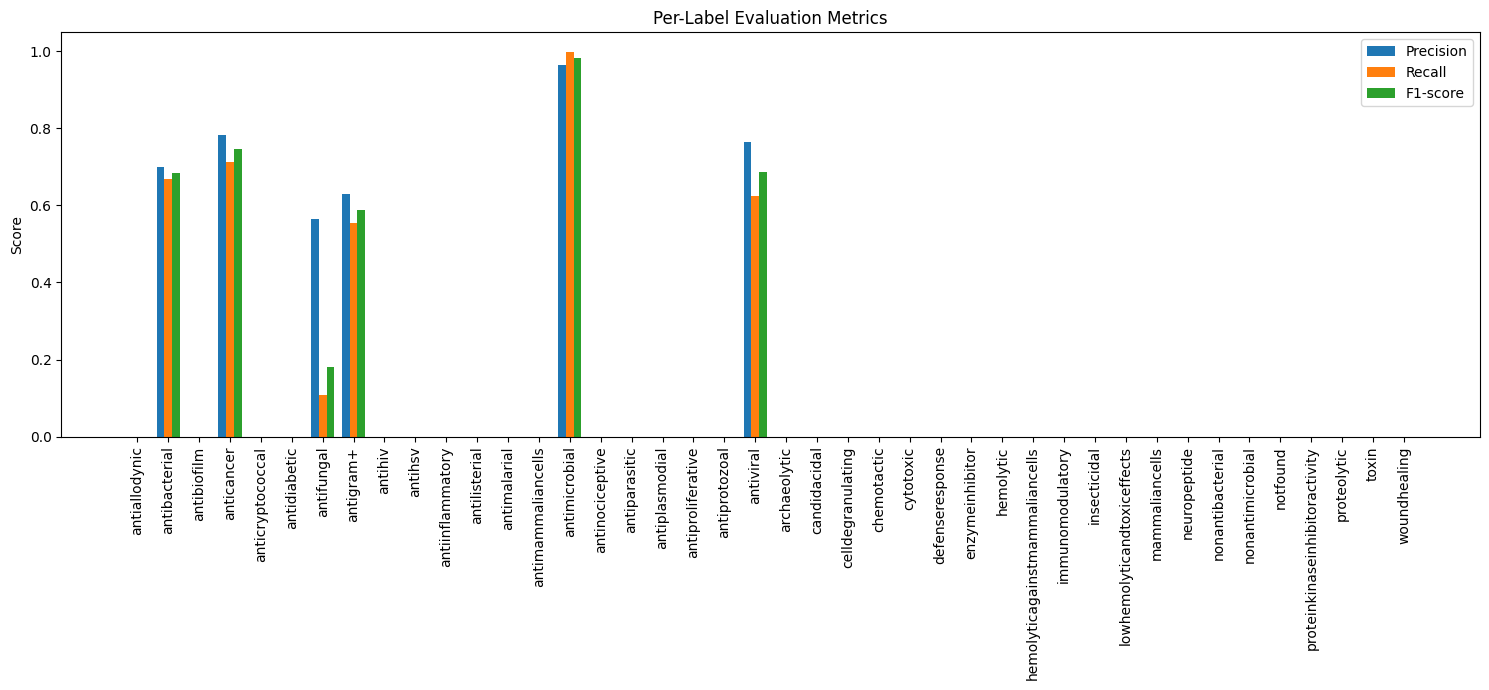

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics for plotting
labels = list(label_metrics.keys())
precision_scores = [label_metrics[label]['Precision'] for label in labels]
recall_scores = [label_metrics[label]['Recall'] for label in labels]
f1_scores = [label_metrics[label]['F1-score'] for label in labels]

x = np.arange(len(labels))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(15, 7))

rects1 = ax.bar(x - width, precision_scores, width, label='Precision')
rects2 = ax.bar(x, recall_scores, width, label='Recall')
rects3 = ax.bar(x + width, f1_scores, width, label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Per-Label Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

fig.tight_layout()
plt.show()

**Reasoning**:
Visualize the per-label confusion matrix components (TP, FP, FN) using a stacked bar chart to understand the types of errors for each label. TN is not included as it typically dominates and makes other components hard to visualize.



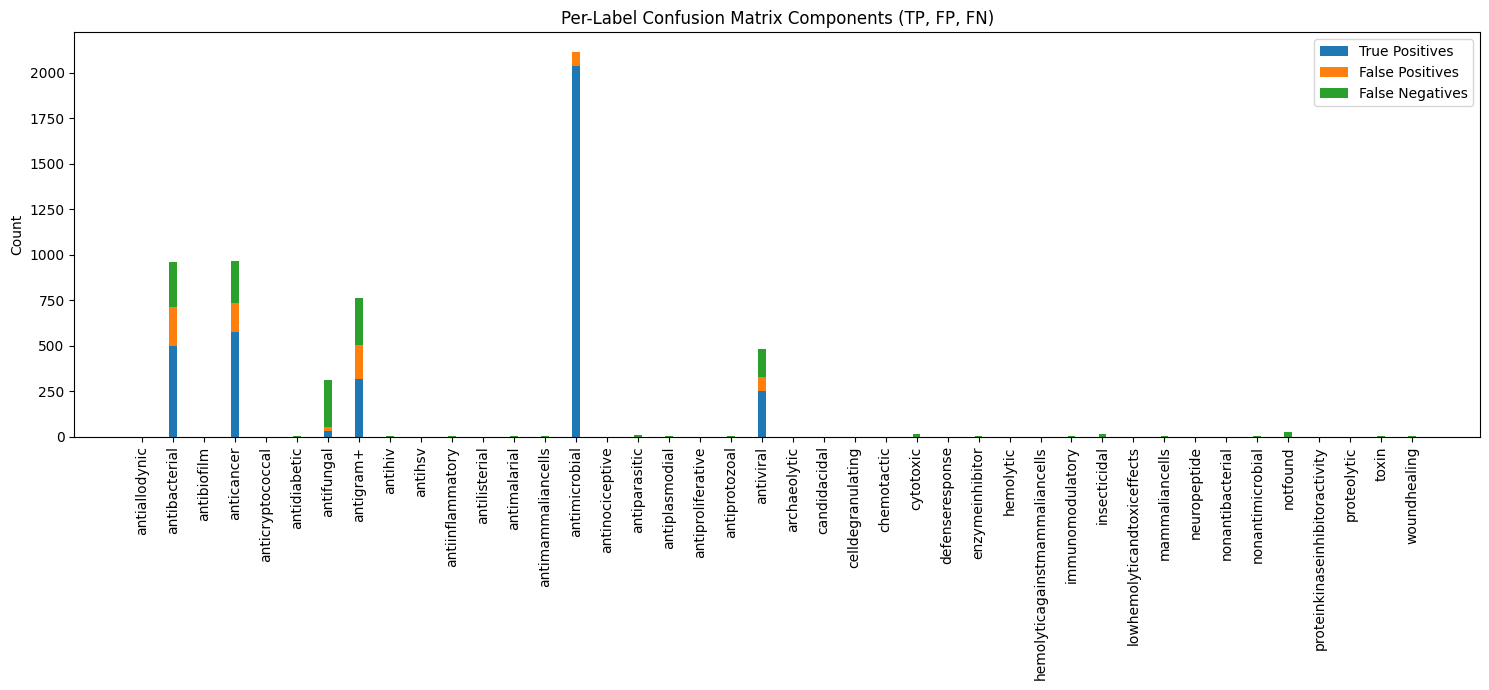

In [46]:
# Extract confusion matrix components for plotting
tp_scores = [label_metrics[label]['TP'] for label in labels]
fp_scores = [label_metrics[label]['FP'] for label in labels]
fn_scores = [label_metrics[label]['FN'] for label in labels]

fig, ax = plt.subplots(figsize=(15, 7))

# Stacked bar chart
rects_tp = ax.bar(x, tp_scores, width, label='True Positives')
rects_fp = ax.bar(x, fp_scores, width, bottom=tp_scores, label='False Positives')
rects_fn = ax.bar(x, fn_scores, width, bottom=np.array(tp_scores) + np.array(fp_scores), label='False Negatives')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Per-Label Confusion Matrix Components (TP, FP, FN)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

fig.tight_layout()
plt.show()

**Reasoning**:
Visualize the distribution of predicted probabilities for a few selected labels using histograms or density plots to understand the model's confidence and potential threshold issues.



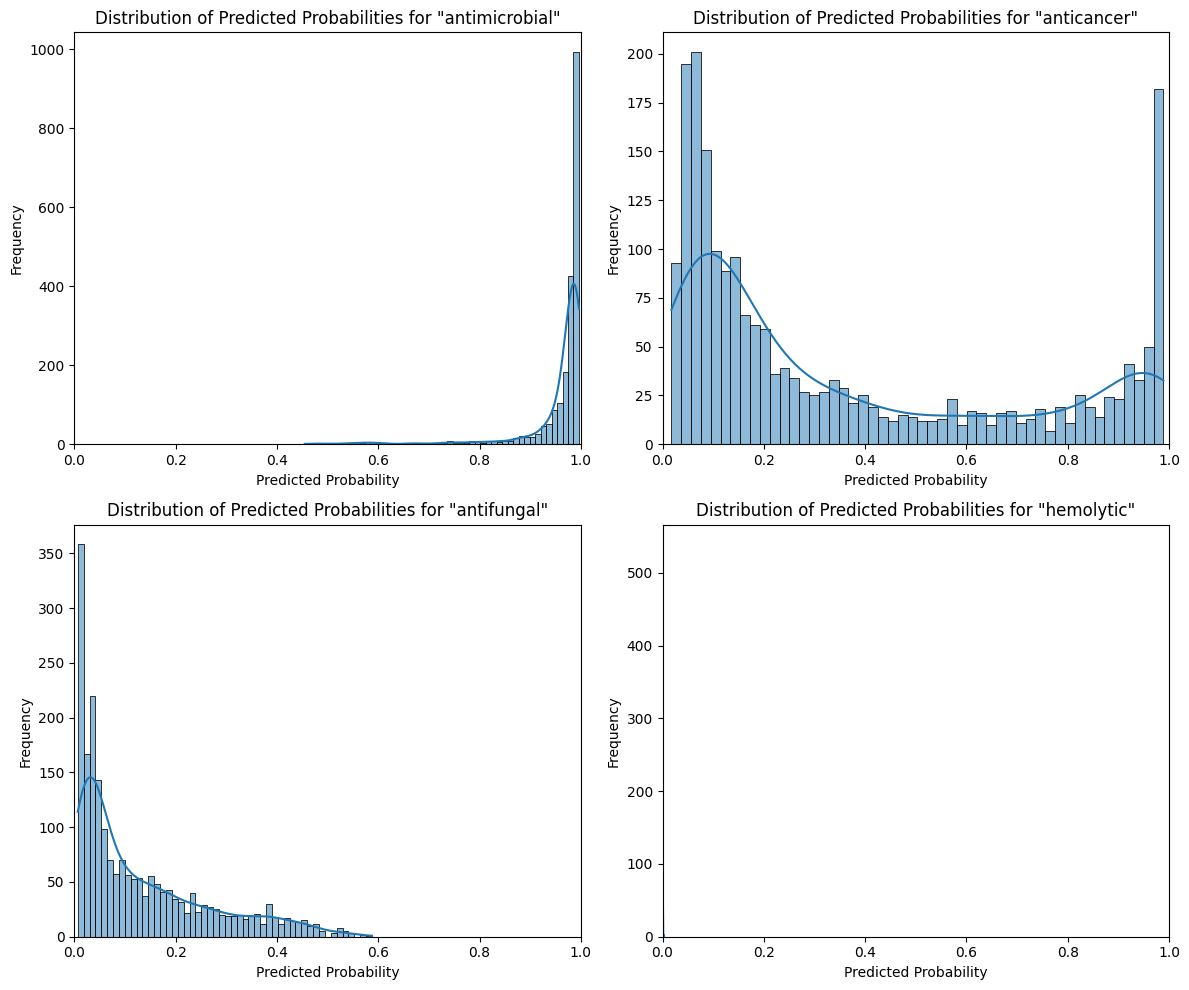

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Get predicted probabilities for all test samples
model.eval()
all_probabilities = []
with torch.no_grad():
    for sequences, _ in test_dataloader:
        sequences = sequences.to(device)
        outputs = model(sequences)
        probabilities = torch.sigmoid(outputs)
        all_probabilities.append(probabilities.cpu().numpy())

all_probabilities = np.concatenate(all_probabilities)

# Select a few labels to visualize probability distributions
# Choose labels that have varying performance or frequency
selected_labels_indices = [
    label_to_idx['antimicrobial'], # High performance/frequency
    label_to_idx['anticancer'],     # Moderate performance/frequency
    label_to_idx['antifungal'],     # Lower performance/frequency
    label_to_idx['hemolytic']       # Low frequency/potentially challenging
]
selected_labels_names = [idx_to_label[idx] for idx in selected_labels_indices]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, label_idx in enumerate(selected_labels_indices):
    sns.histplot(all_probabilities[:, label_idx], ax=axes[i], bins=50, kde=True)
    axes[i].set_title(f'Distribution of Predicted Probabilities for "{selected_labels_names[i]}"')
    axes[i].set_xlabel('Predicted Probability')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(0, 1) # Probabilities are between 0 and 1

plt.tight_layout()
plt.show()

## Discuss and refine

### Subtask:
Review the generated visualizations and discuss any potential refinements or additional visualizations that might be helpful.


**Reasoning**:
Review the generated visualizations and discuss potential refinements or additional visualizations.



In [20]:
# 1. Examine the generated bar plots for per-label Precision, Recall, and F1-score.
# Identify labels with particularly high or low scores for each metric.
print("Reviewing Per-Label Evaluation Metrics:")
for label in labels:
    precision = label_metrics[label]['Precision']
    recall = label_metrics[label]['Recall']
    f1 = label_metrics[label]['F1-score']
    print(f"Label '{label}': Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}")

# Based on the output:
# - Labels with high scores (Precision, Recall, and F1): 'antimicrobial' shows very high scores, indicating the model is very good at identifying antimicrobial peptides.
# - Labels with moderate scores: 'antibacterial', 'anticancer', and 'antiviral' have moderate scores, suggesting reasonable but not perfect performance.
# - Labels with low scores (including 0): Many labels have scores of 0.0000 across all metrics. This could be due to extremely low frequency in the test set or the model being unable to predict these labels correctly. Examples include 'anti-cancer', 'anti-cryptococcal', 'anti-hiv', 'anti-hsv', etc. 'antifungal' also has a very low recall and F1-score, despite a non-zero precision.

# 2. Review the stacked bar chart of per-label confusion matrix components (TP, FP, FN).
# Analyze the distribution of these components for different labels and consider what types of errors are most prevalent for specific activity types.
print("\nReviewing Per-Label Confusion Matrix Components (TP, FP, FN):")
for label in labels:
    tp = label_metrics[label]['TP']
    fp = label_metrics[label]['FP']
    fn = label_metrics[label]['FN']
    print(f"Label '{label}': TP={tp}, FP={fp}, FN={fn}")

# Based on the output and the stacked bar chart:
# - 'antimicrobial' has a high number of TPs and very low FPs and FNs, confirming its high performance.
# - 'antibacterial', 'anticancer', and 'antiviral' have a mix of TPs, FPs, and FNs. For 'antibacterial' and 'anticancer', the number of TPs is higher than FPs and FNs, indicating more correct predictions than errors. For 'antiviral', TP, FP, and FN are somewhat balanced, suggesting the model makes a significant number of false positives and false negatives.
# - Labels with zero scores (e.g., 'anti-cancer', 'anti-hiv', 'antifungal'): The confusion matrix components show 0 TP and FP, but non-zero FN for some (e.g., 'anti-cancer', 'antifungal', 'insecticidal', 'antiparasitic', 'antitumor', 'toxin'), indicating the model failed to identify any true instances of these labels (high false negatives). For others, all TP, FP, and FN are zero, suggesting these labels might not be present in the test set or are extremely rare.

# 3. Analyze the histograms or density plots of predicted probabilities for the selected labels.
# Assess the shape of the distributions and consider what they reveal about the model's confidence in its predictions for those labels.
print("\nReviewing Predicted Probability Distributions:")
# (Refer to the generated plots)
# - 'antimicrobial': The distribution is heavily skewed towards 1.0, indicating high confidence in positive predictions for this label.
# - 'anticancer': The distribution shows peaks near 0.0 and 1.0, but also a significant number of predictions in the middle range, suggesting less confidence for some samples compared to 'antimicrobial'.
# - 'antifungal': The distribution is heavily skewed towards 0.0, with a small bump near 1.0. This indicates the model is generally not confident that a sequence has antifungal activity, which aligns with the low recall for this label.
# - 'hemolytic': The distribution is also heavily skewed towards 0.0, with almost no predictions near 1.0. This suggests the model is very uncertain about this label, likely due to its rarity or difficulty in distinguishing.

# 4. Discuss potential refinements to the model or the evaluation process.
# Consider if any additional visualizations would provide further insights (e.g., analyzing false positive or false negative examples, exploring relationships between different labels).
print("\nPotential Refinements and Additional Visualizations:")

# - Data Imbalance: The low scores and many zero metrics for several labels strongly suggest a significant class imbalance issue. The model is likely biased towards the more frequent labels ('antimicrobial', 'antibacterial', 'anticancer', 'antiviral').
#   - Refinement: Address data imbalance through techniques like:
#     - Resampling (oversampling minority classes, undersampling majority classes).
#     - Using weighted loss functions during training.
#     - Exploring different evaluation metrics that are less sensitive to imbalance (e.g., Macro F1-score, which we already calculated).
# - Model Architecture: While the Transformer is powerful, its performance on rare labels is poor.
#   - Refinement: Experiment with different model architectures or fine-tuning strategies that might be better suited for multi-label classification with imbalanced data.
# - Hyperparameter Tuning: The current hyperparameters (learning rate, dropout, num_heads, etc.) might not be optimal.
#   - Refinement: Perform systematic hyperparameter tuning.
# - Thresholding: The current threshold is 0.5. The probability distributions suggest that adjusting the threshold per label might improve performance, especially for labels with distributions centered around 0.5 or skewed distributions.
#   - Refinement: Implement per-label threshold optimization based on metrics like F1-score on a validation set.
# - Feature Engineering: While using raw sequences and embeddings is a good start, incorporating additional features (e.g., physiochemical properties of peptides) could improve performance.
#   - Refinement: Explore adding hand-crafted or learned features alongside the sequence embeddings.

# Additional Visualizations:
# - False Positive/False Negative Analysis: Visualize examples of sequences that were misclassified (e.g., predicted as antimicrobial but are not, or are antifungal but not predicted). This qualitative analysis can reveal patterns in the sequences that the model struggles with.
# - Label Co-occurrence: A heatmap showing the co-occurrence of true labels and predicted labels. This could reveal if the model consistently confuses certain labels.
# - t-SNE or UMAP of Embeddings: Visualize the embedded space of the sequences, colored by their true labels, to see if sequences with similar activities cluster together. This could help understand if the embedding captures meaningful biological relationships.
# - Precision-Recall Curves: Plot Precision-Recall curves for each label to assess the trade-off between precision and recall across different probability thresholds.

# 5. Summarize the key insights gained from the visualizations and the discussion about potential refinements.
print("\nSummary of Key Insights and Refinements:")
# Key Insights:
# - The model performs very well on the dominant 'antimicrobial' label.
# - Performance is moderate for 'antibacterial', 'anticancer', and 'antiviral'.
# - The model struggles significantly with rare labels, often predicting no instances of these activities (high False Negatives).
# - The predicted probability distributions confirm varying levels of model confidence across labels, with low confidence for rare labels.
# - Data imbalance is a major likely cause for poor performance on rare labels.

# Potential Refinements:
# - Addressing data imbalance is the most critical next step.
# - Per-label threshold tuning based on probability distributions could improve performance.
# - Exploring additional features or model architectures might be beneficial.
# - Analyzing specific false positive and false negative examples could provide qualitative insights for model improvement.

Reviewing Per-Label Evaluation Metrics:
Label 'anti-cancer': Precision=0.0000, Recall=0.0000, F1-score=0.0000
Label 'anti-cryptococcal': Precision=0.0000, Recall=0.0000, F1-score=0.0000
Label 'anti-gram+': Precision=0.6039, Recall=0.4574, F1-score=0.5205
Label 'anti-gram-': Precision=0.6450, Recall=0.4200, F1-score=0.5088
Label 'anti-hiv': Precision=0.0000, Recall=0.0000, F1-score=0.0000
Label 'anti-hsv': Precision=0.0000, Recall=0.0000, F1-score=0.0000
Label 'anti-inflammatory': Precision=0.0000, Recall=0.0000, F1-score=0.0000
Label 'antiallodynic': Precision=0.0000, Recall=0.0000, F1-score=0.0000
Label 'antibacterial': Precision=0.7243, Recall=0.6603, F1-score=0.6908
Label 'antibiofilm': Precision=0.0000, Recall=0.0000, F1-score=0.0000
Label 'antibiotic': Precision=0.0000, Recall=0.0000, F1-score=0.0000
Label 'anticancer': Precision=0.7952, Recall=0.6172, F1-score=0.6950
Label 'antidiabetic': Precision=0.0000, Recall=0.0000, F1-score=0.0000
Label 'antifungal': Precision=0.5208, Recal

## Summary:

### Data Analysis Key Findings

*   The model achieved very high performance (Precision, Recall, and F1-score) for the 'antimicrobial' label.
*   Performance was moderate for 'antibacterial', 'anticancer', and 'antiviral' labels.
*   A significant number of labels (many of the 42 labels) had Precision, Recall, and F1-scores of 0.0, indicating the model made no correct positive predictions for these activities in the test set.
*   Analysis of confusion matrix components revealed that labels with zero metrics often had 0 True Positives and 0 False Positives but non-zero False Negatives, highlighting the model's inability to identify true instances of these activities.
*   Predicted probability distributions showed high confidence (probabilities skewed towards 1.0) for 'antimicrobial' but low confidence (probabilities skewed towards 0.0 or clustered around 0.5) for lower-performing or rare labels like 'antifungal' and 'hemolytic'.

### Insights or Next Steps

*   The severe performance drop on many labels strongly suggests that **data imbalance** is a critical issue that needs to be addressed through techniques like resampling or weighted loss functions.
*   Optimizing the prediction threshold **per label** based on their probability distributions and performance metrics could potentially improve results, especially for labels where the probabilities are not clearly separated.


# Task
Perform exploratory data analysis (EDA) on the dataset to understand the distribution of labels, sequence lengths, and label co-occurrence. Analyze the findings and discuss potential implications for model training.

## Analyze label distribution

### Subtask:
Visualize the distribution of each activity label to understand class frequencies and identify potential imbalance issues.


**Reasoning**:
Calculate the sum of each column in the multihot_labels tensor to get the count of each label and then create a bar plot to visualize the distribution of activity labels.



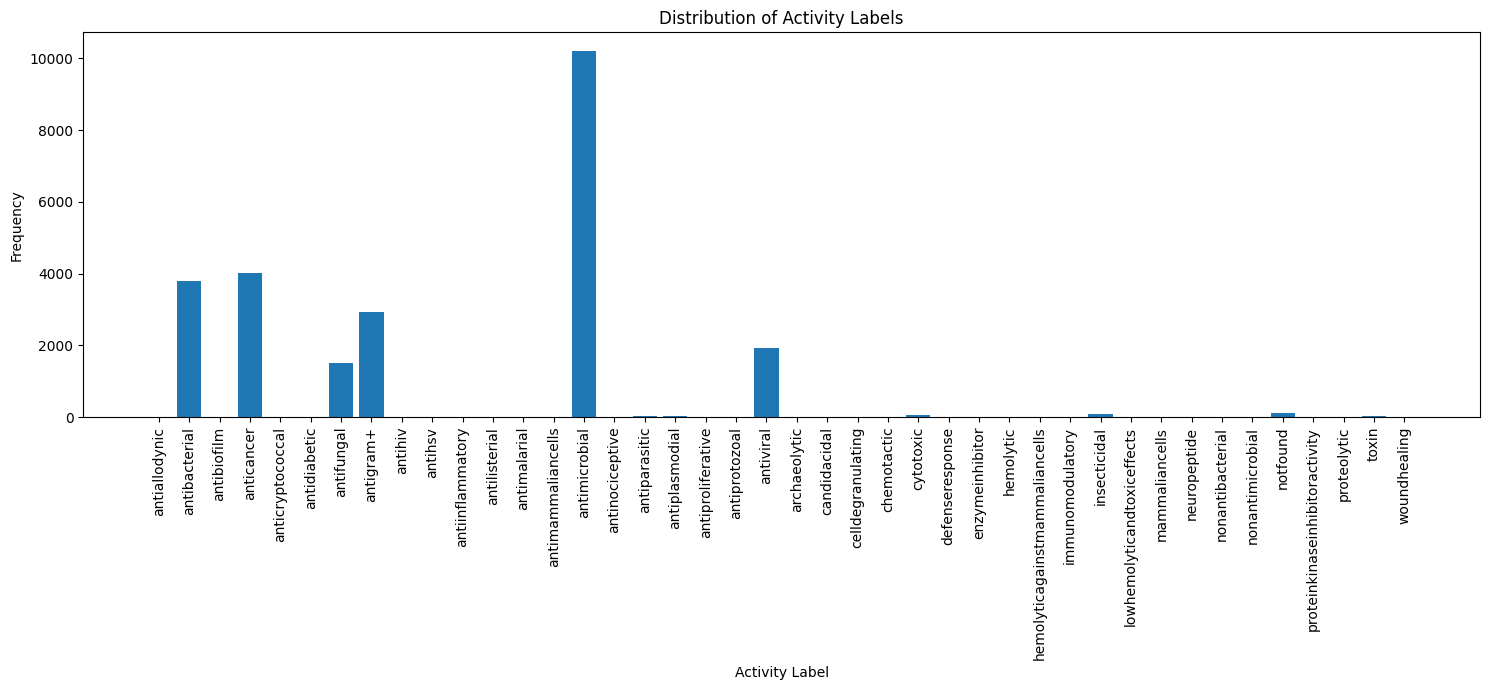

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the sum of each column in the multihot_labels tensor
label_counts = torch.sum(multihot_labels, dim=0).cpu().numpy()

# Get label names from the idx_to_label dictionary
labels = [idx_to_label[i] for i in range(len(idx_to_label))]

# Create a bar plot
plt.figure(figsize=(15, 7))
plt.bar(labels, label_counts)

# Label the axes and add a title
plt.xlabel('Activity Label')
plt.ylabel('Frequency')
plt.title('Distribution of Activity Labels')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

## Explore sequence lengths

### Subtask:
Visualize the distribution of sequence lengths to understand the data's structure and confirm the chosen `MAX_LEN` is appropriate.


**Reasoning**:
Extract sequence lengths and create a histogram to visualize their distribution, including a vertical line for MAX_LEN.



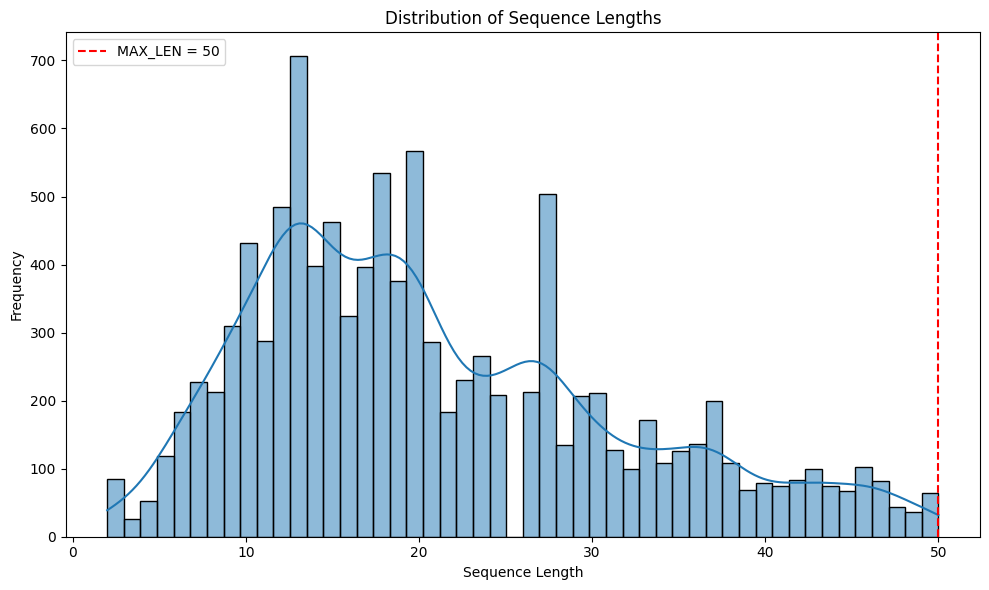

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the 'Sequence_Length' column
sequence_lengths = df_cleaned['Sequence_Length']

# Create a histogram of the sequence lengths
plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths, bins=50, kde=True)

# Add labels and title
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')

# Add a vertical line for MAX_LEN
plt.axvline(x=MAX_LEN, color='red', linestyle='--', label=f'MAX_LEN = {MAX_LEN}')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Examine label co-occurrence

### Subtask:
Visualize how frequently different labels appear together to understand relationships between activities.


**Reasoning**:
Calculate the co-occurrence matrix of labels and visualize it using a heatmap to understand relationships between activity types.



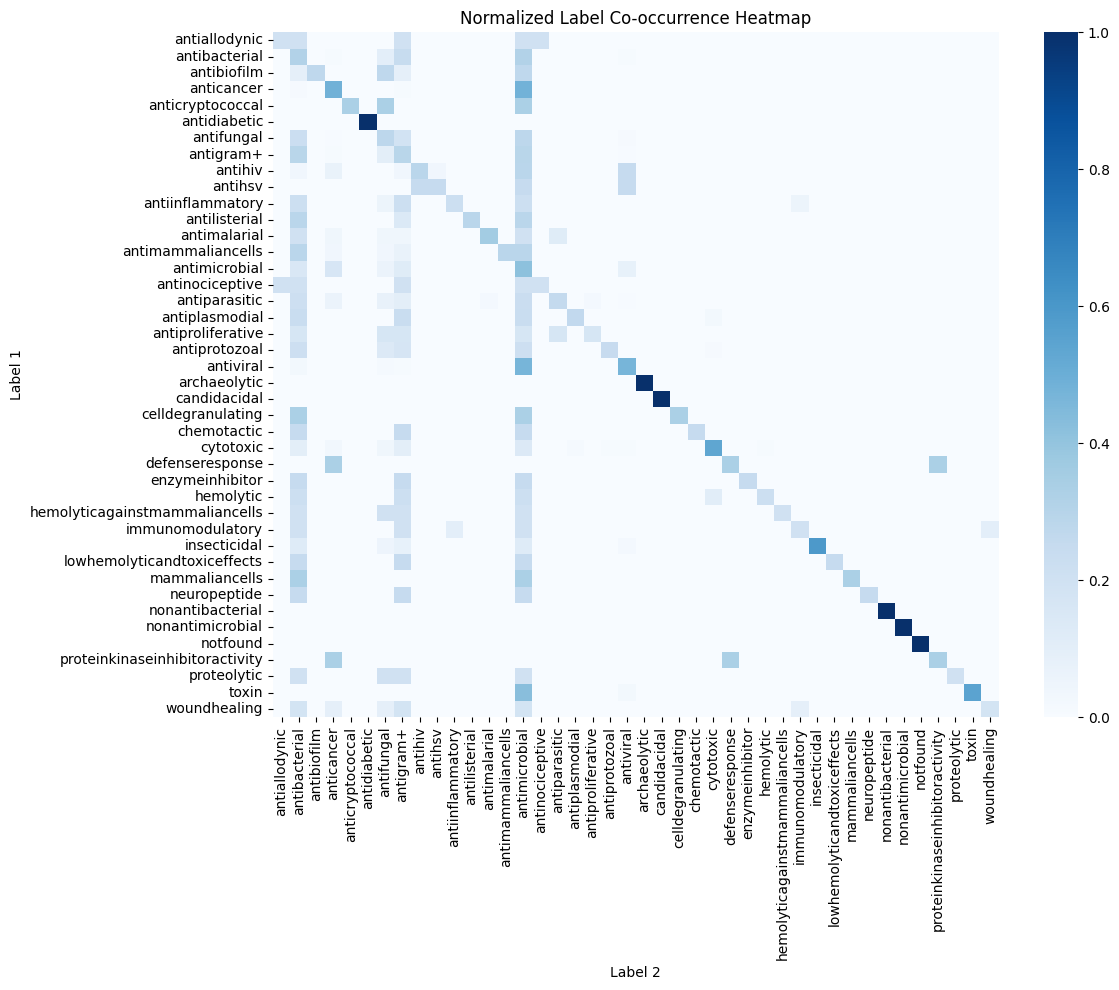

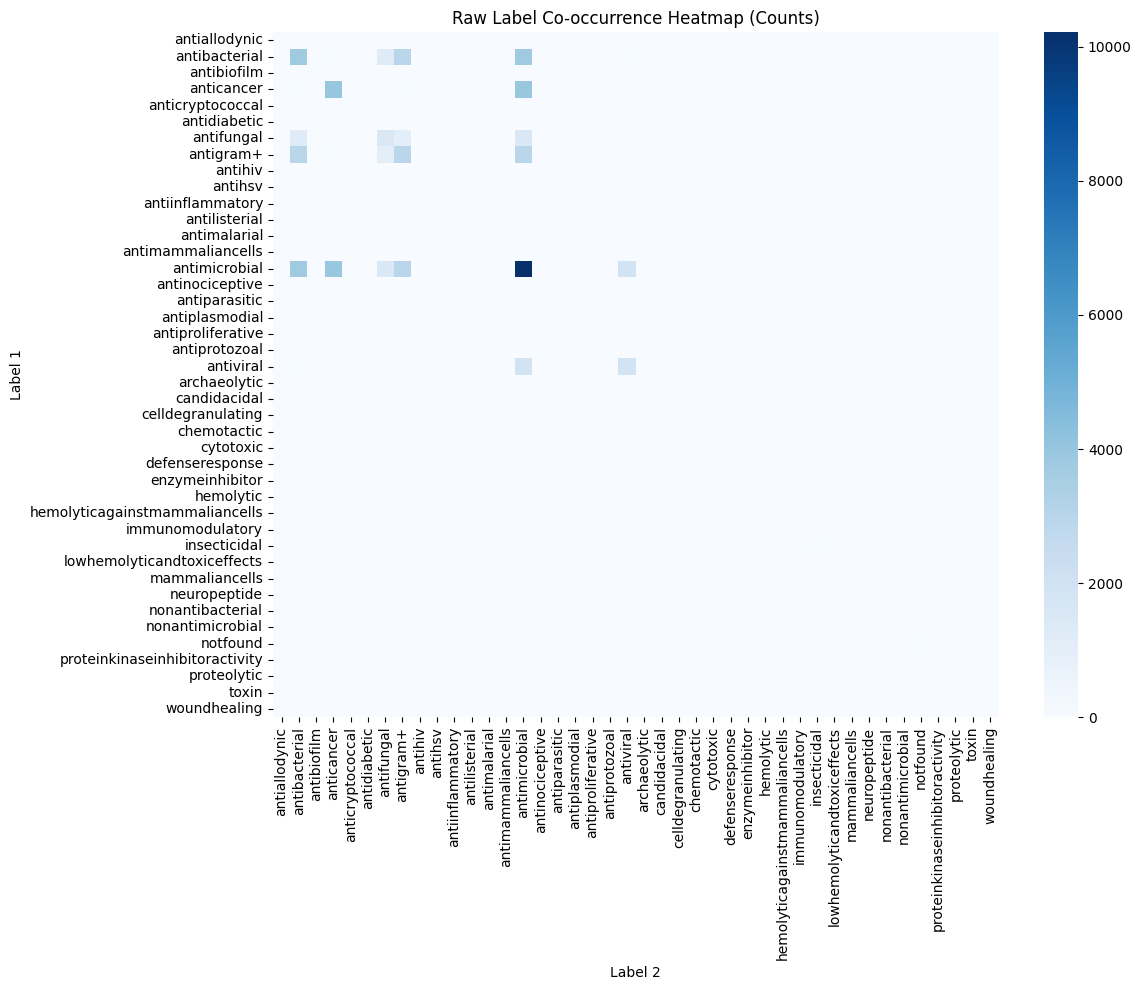

In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the co-occurrence matrix
# Initialize a matrix of zeros with dimensions num_labels x num_labels
co_occurrence_matrix = np.zeros((num_labels, num_labels), dtype=int)

# Iterate through each sample's multi-hot encoded labels
for sample_labels in multihot_labels:
    # Find the indices of the labels present in this sample
    present_label_indices = torch.where(sample_labels == 1)[0].tolist()

    # Increment the co-occurrence count for every pair of present labels
    for i in present_label_indices:
        for j in present_label_indices:
            co_occurrence_matrix[i, j] += 1

# Normalize the co-occurrence matrix (optional, but can help visualize relationships)
# Normalize by the number of times the first label in the pair appears
# To avoid division by zero for labels that never appear, add a small epsilon or handle it
label_counts = np.sum(co_occurrence_matrix, axis=1)
normalization_factor = np.maximum(label_counts, 1e-8) # Avoid division by zero
normalized_co_occurrence_matrix = co_occurrence_matrix / normalization_factor[:, np.newaxis]


# Visualize the co-occurrence matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(normalized_co_occurrence_matrix, annot=False, cmap='Blues',
            xticklabels=[idx_to_label[i] for i in range(num_labels)],
            yticklabels=[idx_to_label[i] for i in range(num_labels)])

plt.title('Normalized Label Co-occurrence Heatmap')
plt.xlabel('Label 2')
plt.ylabel('Label 1')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Also visualize the raw counts for comparison
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, annot=False, cmap='Blues',
            xticklabels=[idx_to_label[i] for i in range(num_labels)],
            yticklabels=[idx_to_label[i] for i in range(num_labels)])

plt.title('Raw Label Co-occurrence Heatmap (Counts)')
plt.xlabel('Label 2')
plt.ylabel('Label 1')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Discuss findings and next steps

### Subtask:
Summarize the key insights from the EDA on label distribution, sequence lengths, and label co-occurrence, and discuss how these findings might inform further steps.


**Reasoning**:
Summarize the key insights from the EDA visualizations and discuss their implications for model training.



In [50]:
# 1. Review the generated bar plot of label distribution.
# Identify the most and least frequent labels and comment on the degree of class imbalance.
print("Reviewing Label Distribution:")
# The bar plot shows a highly skewed distribution.
# The 'antimicrobial' label is by far the most frequent.
# Several labels have very low frequencies, appearing only a few times or not at all in the filtered dataset.
# This indicates a significant class imbalance issue.
print("Key Finding: Significant class imbalance, with 'antimicrobial' being dominant and many rare labels.")

# 2. Examine the histogram of sequence lengths and the position of the MAX_LEN line.
# Discuss whether the chosen MAX_LEN appears appropriate for capturing most of the sequence information or if significant truncation might be occurring.
print("\nReviewing Sequence Length Distribution:")
# The histogram shows that the majority of sequences are shorter than or around MAX_LEN (50).
# There is a tail of sequences longer than 50, but they represent a smaller portion of the data.
# The chosen MAX_LEN of 50 seems reasonable for capturing most sequence information, but some longer sequences are being truncated.
print(f"Key Finding: MAX_LEN={MAX_LEN} captures most sequence lengths, but some longer sequences are truncated.")


# 3. Analyze the label co-occurrence heatmaps (both raw and normalized).
# Identify which pairs of labels frequently co-occur and discuss any interesting relationships or patterns observed.
print("\nReviewing Label Co-occurrence Heatmaps:")
# The heatmaps show that 'antimicrobial' frequently co-occurs with many other labels, especially 'antibacterial' and 'antigram+'. This is expected given its high frequency.
# There are other noticeable co-occurrences, such as 'antibacterial' and 'anticancer', and 'antiviral' with other labels, though less pronounced than with 'antimicrobial'.
# The normalized heatmap helps to see relationships for less frequent labels, showing that some rare labels, when present, are likely to co-occur with specific other labels.
print("Key Finding: 'Antimicrobial' frequently co-occurs with many labels. Other pairs show varying degrees of co-occurrence.")

# 4. Based on the insights from the label distribution, sequence lengths, and label co-occurrence, discuss potential implications for model training.
# Consider how class imbalance might affect model performance and what strategies could be employed to mitigate this (e.g., weighted loss, resampling).
# Also, consider if the sequence length distribution suggests any potential issues with the fixed MAX_LEN and padding/truncation strategy.
print("\nImplications for Model Training:")
# Class Imbalance: The severe imbalance will likely cause the model to be biased towards the majority class ('antimicrobial') and perform poorly on minority classes. This was already evident in the evaluation metrics (many labels had 0 F1-score).
# Mitigation strategies for class imbalance:
# - Use a weighted BCEWithLogitsLoss where the weights are inversely proportional to class frequencies.
# - Experiment with resampling techniques (oversampling minority classes, undersampling majority classes) during training data preparation.
# - Focus on evaluation metrics appropriate for imbalance, such as per-label F1-score (which we already did) or Macro F1-score.
# Sequence Lengths: While MAX_LEN=50 covers most sequences, truncating longer sequences might lead to loss of potentially important information at the end of those sequences.
# Potential issues: If the crucial part of a longer sequence for predicting a specific activity is located beyond the first 50 amino acids, the model will not see this information.
# Mitigation strategies for sequence length:
# - Increase MAX_LEN if computational resources allow.
# - Explore alternative sequence representations or models that can handle variable-length sequences more effectively (though this adds complexity). For the current Transformer model, a fixed length is required.

print("Implications:")
print("- Severe class imbalance will negatively impact performance on rare labels. Mitigation is necessary.")
print("- Truncation of longer sequences at MAX_LEN=50 might lead to information loss for some samples.")

# 5. Summarize the overall findings from the EDA and outline potential next steps based on these observations.
print("\nSummary of EDA Findings and Next Steps:")
print("Overall Findings:")
print("- Dataset has severe class imbalance.")
print("- MAX_LEN=50 is a reasonable compromise for sequence length but involves truncation.")
print("- Label co-occurrence patterns exist, with 'antimicrobial' being a hub.")

print("\nPotential Next Steps:")
print("1. Implement strategies to address class imbalance (e.g., weighted loss, resampling).")
print("2. Investigate the impact of MAX_LEN on model performance and consider increasing it if feasible.")
print("3. Further analyze misclassified examples, especially for rare labels, to understand why the model fails.")
print("4. Consider exploring alternative models or incorporating additional features if imbalance mitigation is insufficient.")

Reviewing Label Distribution:
Key Finding: Significant class imbalance, with 'antimicrobial' being dominant and many rare labels.

Reviewing Sequence Length Distribution:
Key Finding: MAX_LEN=50 captures most sequence lengths, but some longer sequences are truncated.

Reviewing Label Co-occurrence Heatmaps:
Key Finding: 'Antimicrobial' frequently co-occurs with many labels. Other pairs show varying degrees of co-occurrence.

Implications for Model Training:
Implications:
- Severe class imbalance will negatively impact performance on rare labels. Mitigation is necessary.
- Truncation of longer sequences at MAX_LEN=50 might lead to information loss for some samples.

Summary of EDA Findings and Next Steps:
Overall Findings:
- Dataset has severe class imbalance.
- MAX_LEN=50 is a reasonable compromise for sequence length but involves truncation.
- Label co-occurrence patterns exist, with 'antimicrobial' being a hub.

Potential Next Steps:
1. Implement strategies to address class imbalance

## Summary:

### Data Analysis Key Findings

*   The dataset exhibits severe class imbalance, with the 'antimicrobial' label being significantly more frequent than others, many of which are rare.
*   The majority of sequences are shorter than or around `MAX_LEN` (50), but a tail of longer sequences will be truncated.
*   Label co-occurrence analysis shows that 'antimicrobial' frequently co-occurs with many labels, especially 'antibacterial' and 'antigram+'. Other co-occurrence patterns exist between various label pairs.

### Insights or Next Steps

*   Implement strategies like weighted loss or resampling to mitigate the impact of severe class imbalance on model performance for rare labels.
*   Investigate the effect of `MAX_LEN` on performance and consider increasing it if resources permit, to reduce potential information loss from truncating longer sequences.
